In [ ]:
#!pip install opencage --quiet
#from opencage.geocoder import OpenCageGeocode
#!pip install opencage --quiet

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import lxml
import time
import folium
import random
import requests
import warnings
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup
from matplotlib import pyplot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from pandas.io.json import json_normalize
from sklearn.ensemble import RandomForestRegressor
#from opencage.geocoder import OpenCageGeocode

In [ ]:
%matplotlib notebook
warnings.filterwarnings('ignore')
#pd.set_option('display.max_rows',9)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [ ]:
cities = pd.DataFrame({'city':['London']})
#cities = pd.DataFrame({'city':['London','Toronto','New York']})
#cities = pd.DataFrame({'city':['London','Birmingham','Liverpool']})
cities = pd.DataFrame({'city':['London','Birmingham','Liverpool','Nottingham','Sheffield','Bristol','Glasgow','Leicester','Edinburgh','Leeds']})
#cities = pd.DataFrame({'city':['London','Birmingham','Liverpool','Nottingham','Sheffield','Bristol','Glasgow','Leicester','Edinburgh','Leeds'
#                               ,'Cardiff','Manchester','Stoke','Coventry','Sunderland','Birkenhead','Islington','Reading','Hull','Preston'
#                               ,'Newport','Swansea']}) # more than 200K
#cities = pd.DataFrame({'city':['London']})
cities

In [ ]:
#def getNearbyVenues(cities,category,radius = 500,limit = 3):  
def getNearbyVenues(cities,category,radius = 10000,limit = 3):  
    venues_list = []
    for city in zip(cities):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,city,category,radius,limit)
        results = requests.get(url).json()['response']['groups'][0]['items']        
        venues_list.append([(city[0],
                             v['venue']['id'],
                             v['venue']['name'],
                             v['venue']['location']['lat'],
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name'])
                            for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city',
                             'venue_id',
                             'venue_name',
                             'venue_latitude',
                             'venue_longitude',
                             'venue_category']
    return(nearby_venues)

In [ ]:
cat = '4bf58dd8d48988d1e0931735' # coffee shop
city_venue = getNearbyVenues(cities = cities['city'],category = cat,limit = 495) #limit = 495, limit = 10000
city_venue

In [ ]:
def get_venue_data(venues):
    venues_list = []
    for vn in venues:
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(vn,CLIENT_ID,CLIENT_SECRET,VERSION)
        global results
        results = requests.get(url).json()['response']['venue']
        try:
            venues_list.append([(results['id'],
                                 results['name'],
                                 results['location']['formattedAddress'],
                                 #results['location']['lat'],
                                 #results['location']['lng'],
                                 results['canonicalUrl'],
                                 results['categories'][0]['name'],
                                 results['verified'],
                                 results['stats']['tipCount'],
                                 results['price']['tier'],
                                 results['price']['message'],
                                 results['price']['currency'],
                                 #results['hasMenu'],
                                 #results['likes']['count'],
                                 #results['likes']['groups'][0]['type'],
                                 #results['likes']['groups'][0]['count'],
                                 #results['likes']['summary'],
                                 results['rating'],
                                 #results['ratingSignals'],
                                 #results['menu']['url'],
                                 results['photos']['count'],
                                 #results['reasons']['items'][0]['summary'],
                                 results['tips']['count'],
                                 #results['tips']['groups'][0]['type'],
                                 #results['tips']['groups'][0]['name'],
                                 #results['tips']['groups'][0]['count'],
                                 #results['tips']['groups'][0]['items'],
                                 #results['hours']['status'],
                                 #results['hours']['timeframes'][0]['days'],
                                 #results['parent']['id']
                                )])
        except:
            print(vn,'Something went wrong')

    df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_venues.columns = ['v_id',
                         'name',
                         'formattedAddress',
                         #'lat',
                         #'lng',
                         'canonicalUrl',
                         'categories',
                         'verified',
                         'tipCount',
                         'tier',
                         'message',
                         'currency',
                         #'hasmenu',
                         #'count',
                         #'groupsType',
                         #'groupsCount',
                         #'summary',
                         'rating',
                         #'ratingSignals',
                         #'menu_url',
                         'photos',
                         'tips',
                         #'tips-groups-type',
                         #'tips-groups-name',
                         #'tips-groups-count',
                         #'tips-groups-items',
                         #'status',
                         #'days'
                        ]
    return(df_venues)

In [ ]:
df = pd.concat([city_venue,get_venue_data(city_venue['venue_id'])],axis = 1,join = 'inner')
#df = df[['city','venue_id','venue_name','venue_latitude','venue_longitude','venue_category','name','canonicalUrl'
#         ,'categories','tipCount','tier','message','rating','photos','tips']]
df = df[['city','venue_id','venue_name','venue_latitude','venue_longitude','venue_category','canonicalUrl'
         ,'categories','tier','message','rating','photos','tips']]
df

In [ ]:
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0", 
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8","Accept-Language":"en-US,en;q=0.5", 
           "Accept-Encoding":"gzip, deflate","DNT":"1","Connection":"close","Upgrade-Insecure-Requests":"1"}

df_wm = pd.DataFrame([])
for i in df.index:
    r = requests.get(df['canonicalUrl'][i] + '/menu',headers = headers) 
    if r:
        print(i,r.status_code,'Web site exists')
        df_wm = pd.concat([df_wm,df.iloc[[i]]],ignore_index = True)
    else:
        print(i,r.status_code,'Web site does not exist')
    time.sleep(random.randint(5,10))

In [ ]:
df_wm

In [ ]:
df_menu = pd.DataFrame([])
for i in df_wm.index:
    url = df_wm.loc[i,'canonicalUrl']+'/menu'
    time.sleep(random.randint(5,10))
    r = requests.get(url,headers = headers)
    soup = BeautifulSoup(r.text,features = 'lxml')
    menu_items = [i.get_text() for i in soup.find_all(class_ = 'title')]
    menu_prices = [i.get_text() for i in soup.find_all(class_ = 'entryPrice')]
    df_menu = pd.concat([df_menu,pd.DataFrame({'venue_id':df_wm.loc[i,'venue_id'],'venue_name':df_wm.loc[i,'venue_name'],'item':menu_items,'price':menu_prices})]
                         ,ignore_index = True)
    print(i,r.status_code,df_wm.loc[i,'venue_name'])

In [ ]:
df_menu = df_menu.loc[(df_menu['price'] != "")]
df_menu.reset_index(inplace = True)
df_menu.drop('index',axis = 1,inplace = True)

In [ ]:
df_venue_menu = pd.merge(df_wm,df_menu.drop('venue_name',axis = 1),how = 'inner',on = 'venue_id',sort = False)
for i in df_venue_menu.index:
    if '.' in df_venue_menu.loc[i,'price']:
        df_venue_menu.loc[i,'price'] = df_venue_menu.loc[i,'price'][:df_venue_menu.loc[i,'price'].find('.') + 3]
df_venue_menu.loc[:,'price'] = df_venue_menu.loc[:,'price'].apply(pd.to_numeric,errors = 'coerce')
df_venue_menu.dropna(inplace = True)
df_venue_menu.reset_index(drop = True,inplace = True)

In [ ]:
mpi = df_venue_menu[['item','price','venue_id']].groupby(['item']).agg({'price':['mean'],'venue_id':[pd.Series.nunique]}) # most popular items
mpi.columns = mpi.columns.map('-'.join).str.strip('-')
mpi.sort_values(by = 'venue_id-nunique',ascending = False,inplace = True)
mpi.reset_index(inplace = True)
mpi = mpi.head(10)
mpi

In [ ]:
city = 'London'
one_city_venues = city_venue.copy()
one_city_venues = one_city_venues.loc[one_city_venues['city'] == city,:]

one_city_venue_map = folium.Map(location = [one_city_venues['venue_latitude'].mean(),one_city_venues['venue_longitude'].mean()],zoom_start = 15)
for venue,lat,lng in zip(one_city_venues['venue_name'],one_city_venues['venue_latitude'],one_city_venues['venue_longitude']):
    label = folium.Popup('{}'.format(venue),parse_html = True)
    folium.CircleMarker([lat,lng],radius = 5,popup = label,color = 'blue',fill = True,fill_color = '#3186cc',fill_opacity = 0.7,
                        parse_html = False).add_to(one_city_venue_map)
one_city_venue_map

In [ ]:
df_venue_menu.head()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

f2 = pd.read_csv("/kaggle/input/capstone-data/capstone_data.csv")

In [ ]:
df2 = f2.copy()
df2.drop_duplicates(keep = 'first',inplace = True)
df2.reset_index(drop = True,inplace = True)

df2 = df2.groupby(df2.drop(['price'],axis = 1).columns.values.tolist(),as_index = False).agg({'price':['min']})
df2.columns = df2.columns.map('-'.join).str.strip('-')
df2.rename(columns = {'price-min':'price'},inplace = True)
df2.reset_index(drop = True, inplace = True)

df3 = df2.copy()
df3_rep = df3.pivot_table(index = ['item'], aggfunc = 'size')
df3_rep = df3_rep.to_frame()
df3_rep.reset_index(level = df3_rep.index.names,inplace = True)
df3_rep.columns = ['item','count']

df3 = pd.merge(df3,df3_rep,how = 'inner',on = 'item',sort = False)
df3.reset_index(drop = True,inplace = True)

df4 = df3.loc[df3['count'] >= 5]
df4.reset_index(drop = True,inplace = True)


In [ ]:
df6 = df4.copy()
df6 = df6[['rating','city','venue_name','tips','message','photos','item','price']]
df6 = pd.pivot_table(df6,values = 'price',index = ['rating','city','venue_name','tips','message','photos']
                     ,columns = ['item'],aggfunc = np.sum,fill_value = 0)
df6.reset_index(drop = False,inplace = True)
df6.columns.name = None


In [ ]:
y = df6.copy()
x = df6.copy()

y = y.loc[:,'rating']
x.drop(['rating','venue_name'],axis = 1,inplace = True)
x = pd.concat([x,pd.get_dummies(x[['city','message']])],axis = 1)
x.drop(['city','message'],axis = 1,inplace = True)
#x.replace(np.nan,0,inplace = True)

In [ ]:
rf = RandomForestRegressor(random_state = 5)
rf.fit(x,y)
importance = rf.feature_importances_

l = []
for i,v in enumerate(importance):
    l.append([x.columns[i],v])

df_l = pd.DataFrame(l,columns = ['feature','importance'])
df_l.sort_values(by = 'importance',ascending = False,inplace = True)
df_l.reset_index(drop = True,inplace = True)
df_l

print(rf.score(x,y))
pyplot.bar(df_l['feature'].head(),df_l['importance'].head())
pyplot.show()
df_l

In [32]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
pd.set_option('display.max_rows',None)

f2 = pd.read_csv("/kaggle/input/capstone-data/capstone_data.csv")

In [33]:
df_vm_proc = f2.copy()

df_vm_proc.drop_duplicates(keep = 'first',inplace = True)
df_vm_proc.reset_index(drop = True,inplace = True)

df_vm_proc = df_vm_proc.groupby(df_vm_proc.drop(['price'],axis = 1).columns.values.tolist(),as_index = False).agg({'price':['min']})
df_vm_proc.columns = df_vm_proc.columns.map('-'.join).str.strip('-')
df_vm_proc.rename(columns = {'price-min':'price'},inplace = True)
df_vm_proc.reset_index(drop = True, inplace = True)

df_rep = df_vm_proc.copy()
df_rep = df_rep.pivot_table(index = ['item'],aggfunc = 'size')
df_rep = df_rep.to_frame()
df_rep.reset_index(level = df_rep.index.names,inplace = True)
df_rep.columns = ['item','count']

df_vm_proc = pd.merge(df_vm_proc,df_rep,how = 'inner',on = 'item',sort = False)
df_vm_proc.reset_index(drop = True,inplace = True)

df_vm_proc = df_vm_proc.loc[df_vm_proc['count'] >= 5]
df_vm_proc.reset_index(drop = True,inplace = True)
#df_vm_proc

In [39]:
df_for_model = df_vm_proc.copy()
df_for_model = df_for_model[['rating','city','venue_name','tips','message','photos','item','price']]
#df_for_model = pd.pivot_table(df_for_model,values = 'price',index = ['rating','city','venue_name','tips','message','photos']
#                              ,columns = ['item'],aggfunc = np.sum,fill_value = 0)
#df_for_model.reset_index(drop = False,inplace = True)
#df_for_model.columns.name = None
df_for_model.sort_values(by = ['city','venue_name','price'],ascending = [True,True,False],inplace = True)
df_for_model.reset_index(drop = True,inplace = True)
df_for_model

,rating,city,venue_name,tips,message,photos,item,price
0,6.8,Birmingham,Jeff Co CU breakroom,7,Cheap,24,Soup of the Day,4.95
1,7.6,Birmingham,Kirklin Clinic Perks,7,Cheap,14,Chai Latte,2.10
2,7.6,Birmingham,Kirklin Clinic Perks,7,Cheap,14,Cappuccino,1.80
3,7.6,Birmingham,Kirklin Clinic Perks,7,Cheap,14,Hot Chocolate,1.80
4,7.6,Birmingham,Kirklin Clinic Perks,7,Cheap,14,Latte,1.80
5,7.6,Birmingham,Kirklin Clinic Perks,7,Cheap,14,Espresso,1.50
6,8.0,Birmingham,Red Cat,14,Moderate,37,Hot Chocolate,2.60
7,8.0,Birmingham,Red Cat,14,Moderate,37,Chai Latte,2.40
8,8.0,Birmingham,Red Cat,14,Moderate,37,Cappuccino,2.30
9,8.0,Birmingham,Red Cat,14,Moderate,37,Latte,2.30


In [64]:
x = df_for_model.copy()
x.drop(['city','rating','venue_name'],axis = 1,inplace = True)
x = pd.concat([x,pd.get_dummies(x[['item']])],axis = 1)
x.drop(['item'],axis = 1,inplace = True)
#x.drop(['tips','photos','price','message'],axis = 1,inplace = True)
x.drop(['message','price'],axis = 1,inplace = True)



y = df_for_model.copy()
y = y.loc[:,'rating']


x

,tips,photos,item_Americano,item_Cappuccino,item_Chai Latte,item_Espresso,item_Flat White,item_Freshly Squeezed Orange Juice,item_Hot Chocolate,item_Latte,item_Macchiato,item_Mocha,item_Soup of the Day
0,7,24,0,0,0,0,0,0,0,0,0,0,1
1,7,14,0,0,1,0,0,0,0,0,0,0,0
2,7,14,0,1,0,0,0,0,0,0,0,0,0
3,7,14,0,0,0,0,0,0,1,0,0,0,0
4,7,14,0,0,0,0,0,0,0,1,0,0,0
5,7,14,0,0,0,1,0,0,0,0,0,0,0
6,14,37,0,0,0,0,0,0,1,0,0,0,0
7,14,37,0,0,1,0,0,0,0,0,0,0,0
8,14,37,0,1,0,0,0,0,0,0,0,0,0
9,14,37,0,0,0,0,0,0,0,1,0,0,0


In [89]:
x = df_for_model.copy()
x = pd.pivot_table(x,values = 'price',index = ['rating','city','venue_name','tips','message','photos']
                   ,columns = ['item'],aggfunc = np.sum,fill_value = 0)
x.reset_index(drop = False,inplace = True)
x.columns.name = None
x.drop(['city','venue_name','message'],axis = 1,inplace = True)


#x = x.loc[x['Cappuccino'] > 1,:]
#x.reset_index(drop = True,inplace = True)

y = x.loc[:,'rating']
x.drop(['rating'],axis = 1,inplace = True)
#x = x[['tips','photos','Cappuccino']]


x



,tips,photos,Americano,Cappuccino,Chai Latte,Espresso,Flat White,Freshly Squeezed Orange Juice,Hot Chocolate,Latte,Macchiato,Mocha,Soup of the Day
0,8,28,2.60,3.00,0.0,2.40,3.00,4.50,3.40,3.00,2.80,0.00,0.00
1,35,57,2.25,2.55,0.0,1.65,2.55,0.00,0.00,2.55,1.75,2.85,4.25
2,26,59,3.00,3.00,0.0,2.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00
3,7,24,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.95
4,34,176,0.00,2.80,0.0,1.80,0.00,3.05,2.80,0.00,1.90,0.00,5.10
5,9,35,2.20,2.30,0.0,1.30,0.00,0.00,0.00,2.30,1.50,2.40,0.00
6,10,18,1.60,1.80,0.0,1.10,0.00,2.75,1.80,1.80,0.00,1.90,0.00
7,16,12,2.10,0.00,2.2,1.65,2.40,2.80,0.00,0.00,1.70,2.60,0.00
8,28,94,0.00,0.00,0.0,0.00,0.00,0.00,2.20,0.00,2.20,0.00,0.00
9,12,29,1.95,2.20,0.0,1.95,2.20,0.00,2.40,2.20,1.95,0.00,3.45


In [90]:
y

0     5.6
1     6.2
2     6.6
3     6.8
4     6.8
5     6.9
6     7.0
7     7.2
8     7.2
9     7.3
10    7.5
11    7.5
12    7.6
13    7.7
14    7.8
15    8.0
16    8.0
17    8.0
18    8.0
19    8.0
20    8.1
21    8.2
Name: rating, dtype: float64

In [91]:
from sklearn import linear_model
from sklearn.metrics import r2_score
lr = linear_model.LinearRegression()

lr_fit = lr.fit(x,y)
print ('Coefficients: ',lr.coef_)
print ('Intercept: ',lr.intercept_)
rating_hat = lr.predict(x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(rating_hat - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((rating_hat - y) ** 2))
print("R2-score: %.2f" % r2_score(rating_hat,y) )

Coefficients:  [ 0.03173227 -0.00941434  0.00305927  0.21115296  0.05261912  0.07715605
  0.03611345 -0.34570289  0.46433662 -0.56251852 -0.254766    0.18396097
 -0.05926581]
Intercept:  7.143429773850272
Mean absolute error: 0.20
Residual sum of squares (MSE): 0.07
R2-score: 0.83


0.8320616073093425


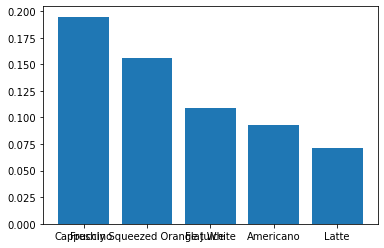

,feature,importance
0,Cappuccino,0.194775
1,Freshly Squeezed Orange Juice,0.156349
2,Flat White,0.108741
3,Americano,0.093369
4,Latte,0.071690
5,Soup of the Day,0.070789
6,photos,0.069907
7,tips,0.069292
8,Espresso,0.065722
9,Mocha,0.035538


In [92]:
rf = RandomForestRegressor(random_state = 5)
rf.fit(x,y)
importance = rf.feature_importances_

l = []
for i,v in enumerate(importance):
    l.append([x.columns[i],v])

df_l = pd.DataFrame(l,columns = ['feature','importance'])
df_l.sort_values(by = 'importance',ascending = False,inplace = True)
df_l.reset_index(drop = True,inplace = True)
df_l

print(rf.score(x,y))
pyplot.bar(df_l['feature'].head(),df_l['importance'].head())
pyplot.show()
df_l